# Non-Negative Matrix Factorization for Predicting Missing Ratings (Recommender System) 

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

In [9]:
#Load the .dat file using pandas, specifying the separator as "::"

column_names = ['userID', 'movieID', 'Rating', 'Timestamp']
data = pd.read_csv('ratings.dat', sep='::', engine='python', header=None,  names=column_names)

df = data.copy().drop('Timestamp', axis = 1)

ratings_matrix = df.pivot(index='userID', columns='movieID', values='Rating')
ratings_matrix_na = ratings_matrix.fillna(0)
ratings_matrix_3 = ratings_matrix.fillna(3)
ratings_matrix_avg = ratings_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

In [43]:
train_x, test_x = train_test_split(df, test_size = 0.3)

test_x_df = test_x.copy()
test_x_mat = test_x_df.pivot(index='userID', columns='movieID', values='Rating')
test_x_mat_0 = test_x_mat.fillna(0)
test_x_mat_3 = test_x_mat.fillna(3)
test_x_mat_avg = test_x_mat.apply(lambda x: x.fillna(x.mean()), axis=1)


In [37]:

def fetch_latent_factors (ratings_matrix):
    
    nmf = NMF(n_components = 10, random_state=42)

    W = nmf.fit_transform(ratings_matrix) 
    H = nmf.components_
    
    
    return np.dot(W, H)


def array_to_df(arr) :
    
    #### remove movies where user did not provide a ratings
    mat_to_df = pd.DataFrame(arr)
    mat_to_df.columns = ratings_matrix.columns.tolist()

    mat_to_df = mat_to_df.reset_index()
    mat_to_df["userID"] =  ratings_matrix.index.tolist()
    mat_to_df.drop(columns = 'index', inplace = True)


    return mat_to_df.melt(id_vars='userID', var_name='movieID', value_name='Rating')


def test_array_to_df(arr) :
    
    #### remove movies where user did not provide a ratings
    mat_to_df = pd.DataFrame(arr)
    mat_to_df.columns = test_x_mat.columns.tolist()

    mat_to_df = mat_to_df.reset_index()
    mat_to_df["userID"] =  test_x_mat.index.tolist()
    mat_to_df.drop(columns = 'index', inplace = True)


    return mat_to_df.melt(id_vars='userID', var_name='movieID', value_name='Rating')

# Predicting on the Test dataset

In [71]:

# Fetch latent factors 

results_test = []


i = 0 
for mat in [test_x_mat_0, test_x_mat_3, test_x_mat_avg]:
    
    names = ['predict to zero', 'predict to 3', 'predict to average']
    
    R_pred  = fetch_latent_factors(mat)
    R_pred_df = test_array_to_df(R_pred)

    # convert wide form array to long form dataframe 
    # filter for test data observations 
    test_ids = test_x.copy()
    test_ids = test_ids.drop(columns = 'Rating')
    predicted_ratings = pd.merge(test_ids, R_pred_df, on = ['userID', 'movieID'])

    # calculate rmse 
    rmse = np.sqrt(mean_squared_error(test_x['Rating'],  predicted_ratings['Rating'])) 

    output = {
        'Utility Matrix': names[i],
        "RMSE": rmse}
    
    i +=1
    results_test.append(output)


In [72]:
results_test

[{'Utility Matrix': 'predict to zero', 'RMSE': 3.3281809882269298},
 {'Utility Matrix': 'predict to 3', 'RMSE': 1.195592708900382},
 {'Utility Matrix': 'predict to average', 'RMSE': 1.0084466425344496}]

# Predicting on the Full dataset

In [67]:


results_full = []
i = 0 

for mat in [ratings_matrix_na, ratings_matrix_3, ratings_matrix_avg]:
    
    names = ['predict to zero', 'predict to 3', 'predict to average']
    
    # Fetch latent factors 
    R_pred  = fetch_latent_factors(mat)
    R_pred_df = array_to_df(R_pred)

    # convert wide form array to long form dataframe 
    # filter for test data observations 
    test_ids = test_x.copy()
    test_ids = test_ids.drop(columns = 'Rating')
    predicted_ratings = pd.merge(test_ids, R_pred_df, on = ['userID', 'movieID'])

    # calculate rmse 
    rmse = np.sqrt(mean_squared_error(test_x['Rating'],  predicted_ratings['Rating'])) 

    output = {
        'Utility Matrix': names[i],
        "RMSE": rmse}
    
    i +=1
    results_full.append(output)


In [68]:
results_full

[{'Utility Matrix': 'predict to zero', 'RMSE': 2.6000984907701445},
 {'Utility Matrix': 'predict to 3', 'RMSE': 1.076552361480837},
 {'Utility Matrix': 'predict to average', 'RMSE': 0.9693377333380649}]

# Discussion


When comparing the performance of NMF with baseline and similarity-based methods, similarity-based approaches outperform NMF. The Root Mean Square Error (RMSE) quantifies the difference between predicted and actual values, with lower values indicating a better model fit. In this analysis, I evaluated movie rating predictions using both a subset of the data and the entire dataset. The results indicate that NMF performs worst when the ratings matrix is imputed with zeros. However, its performance improves when the ratings matrix is imputed with user averages or neutral ratings. Overall, using the full dataset proves more beneficial for achieving a better model fit. When the full matrix is imputed with user averages, NMF’s predictions approach the performance of collaborative filtering methods.

#### Here are some explainations why NMF doesn't always perform as well: 
1.	**Sparsity of Data:** The Movie rating datasets are often very sparse (many missing values). NMF, while useful, may struggle with sparsity because it relies on matrix factorization which assumes a relatively dense interaction pattern.

2.	**Assumptions of Non-Negativity:** NMF enforces non-negativity on the factorized matrices. While this can be beneficial in some contexts, it may not always be suitable for all types of data, especially if the ratings are not strictly positive or if the non-negativity constraint does not align well with the underlying data structure.


3.	**Hyperparameter Sensitivity:** The performance of NMF can be sensitive to hyperparameters like the number of components. Choosing the right number of components is crucial, and a suboptimal choice can lead to poor performance.

4.	**Model Complexity:** NMF can be more complex to tune and train compared to simpler models like mean imputation or user-item similarity-based methods, which are straightforward and might give reasonably good results with less computational effort.


#### Suggestions for Improvement
1.	**Matrix Completion Techniques:** Matrix completion techniques might handle sparsity better. For example, simply imputing the user average or neutral rating value significantly lowers the RMSE. More advanced methods may also lead to improvement. 

2.	**Regularization:** Apply regularization to prevent overfitting and handle sparsity better. The sklearn.decomposition.NMF class provides regularization options like alpha and l1_ratio.

3.	**Hyperparameter Tuning:** Experiment with different numbers of components and other hyperparameters such as L1_ratio or alpha to find the optimal configuration.

4.	**Hybrid Models:** Combine NMF with other methods like collaborative filtering or content-based approaches to leverage the strengths of multiple techniques.


In [73]:

results_NMF_full = pd.DataFrame(results_full)
results_NMF_test = pd.DataFrame(results_test)


results_Similarity = pd.DataFrame({
    'Utility Matrix': ['predict to 3', 'predict to User Average', 'Content based', 'Collaborative-jaccard'],
    'RMSE': [1.26, 1.04, 1.01, 0.95]
})


Text(0, 0.5, 'RMSE')

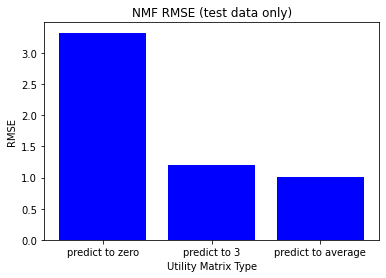

In [74]:
# Plot for results_NMF
plt.bar(results_NMF_test['Utility Matrix'], results_NMF_test['RMSE'], color='blue')
plt.title('NMF RMSE (test data only)')
plt.xlabel('Utility Matrix Type')
plt.ylabel('RMSE')



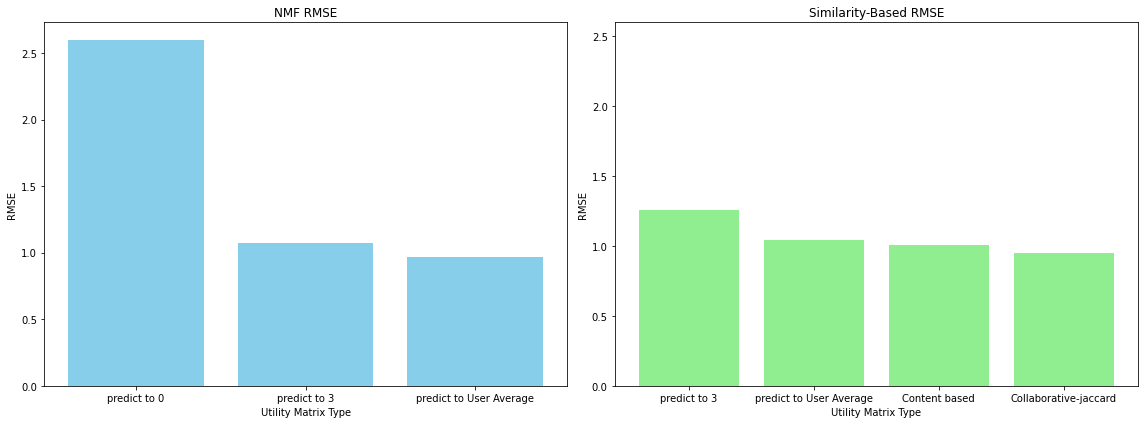

In [36]:
import matplotlib.pyplot as plt

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for results_NMF
ax1.bar(results_NMF['Utility Matrix Type'], results_NMF['RMSE'], color='skyblue')
ax1.set_title('NMF RMSE')
ax1.set_xlabel('Utility Matrix Type')
ax1.set_ylabel('RMSE')
#ax1.tick_params(axis='x', rotation=45, ha='right')

# Plot for results_Similarity
ax2.bar(results_Similarity['Utility Matrix Type'], results_Similarity['RMSE'], color='lightgreen')
ax2.set_title('Similarity-Based RMSE')
ax2.set_xlabel('Utility Matrix Type')
ax2.set_ylabel('RMSE')
#ax2.tick_params(axis='x', rotation=45, ha='right')
ax2.set_ylim(0, 2.6)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
